In [32]:
import pandas as pd
import numpy as np

In [37]:
df = pd.read_csv('train.csv')
df.drop(columns=['product_name', 'category'], inplace=True)
df

,review_text,usefull,unusefull,stars
0,"Заказывали в подарок, коробка пришла не первой...",0,0,5
1,товар пришёл раньше срока спасибо!!!,0,14,5
2,"Красивый,не шумный,но работает только от сети....",2,5,3
3,"как поет в своих песнях Раут ""хороший клоун - ...",1,0,5
4,"Идеально подошла по размеру, все работают",1,0,5
...,...,...,...,...
11693,Все целое и сухое. Доставка в срок. Состав хор...,0,0,5
11694,Хорошо упакованы,0,0,5
11695,"телефон супер,четыре дня держит заряд в постоя...",1,0,5
11696,Прекрасно моет Окна и плитку.,1,0,5


In [34]:
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score


df['net_votes'] = df['usefull'] - df['unusefull']
X_text = df['review_text']
X_num = df[['usefull', 'unusefull', 'net_votes']]
y = df['stars']

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_vec = vectorizer.fit_transform(X_text)

X_train_vec, X_holdout_vec, y_train, y_holdout, idx_train, idx_holdout = train_test_split(
    X_vec, y, df.index, stratify=y, random_state=42
)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_vec, y_train)

nb = MultinomialNB()
nb.fit(X_resampled, y_resampled)

X_nb_all = nb.predict_proba(X_vec)

X_catboost = pd.DataFrame(X_nb_all, columns=[f'nb_proba_{i}' for i in range(1, 6)])
X_catboost = pd.concat([X_catboost, X_num.reset_index(drop=True)], axis=1)

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    auto_class_weights='Balanced',
    verbose=100
)

cat_model.fit(X_catboost, y)
y_pred = cat_model.predict(X_catboost)

print("F1 (macro):", f1_score(y, y_pred, average='macro'))
print("F1 (weighted):", f1_score(y, y_pred, average='weighted'))
print("\n", classification_report(y, y_pred))

0:	learn: 1.3985933	total: 142ms	remaining: 1m 10s
100:	learn: 0.5030914	total: 427ms	remaining: 1.69s
200:	learn: 0.4002660	total: 720ms	remaining: 1.07s
300:	learn: 0.3436042	total: 1.02s	remaining: 672ms
400:	learn: 0.2993116	total: 1.31s	remaining: 323ms
499:	learn: 0.2675675	total: 1.59s	remaining: 0us
F1 (macro): 0.8377759150561722
F1 (weighted): 0.902326321541161

               precision    recall  f1-score   support

           1       0.84      0.94      0.89       956
           2       0.78      0.97      0.86       362
           3       0.70      0.94      0.80       645
           4       0.59      0.86      0.70       947
           5       0.98      0.89      0.93      8788

    accuracy                           0.90     11698
   macro avg       0.78      0.92      0.84     11698
weighted avg       0.92      0.90      0.90     11698



   Feature Id  Importances
0  nb_proba_5    22.018270
1  nb_proba_2    17.674200
2  nb_proba_1    17.589233
3  nb_proba_3    17.413571
4  nb_proba_4    16.881202
5     usefull     3.413594
6   net_votes     3.384470
7   unusefull     1.625460


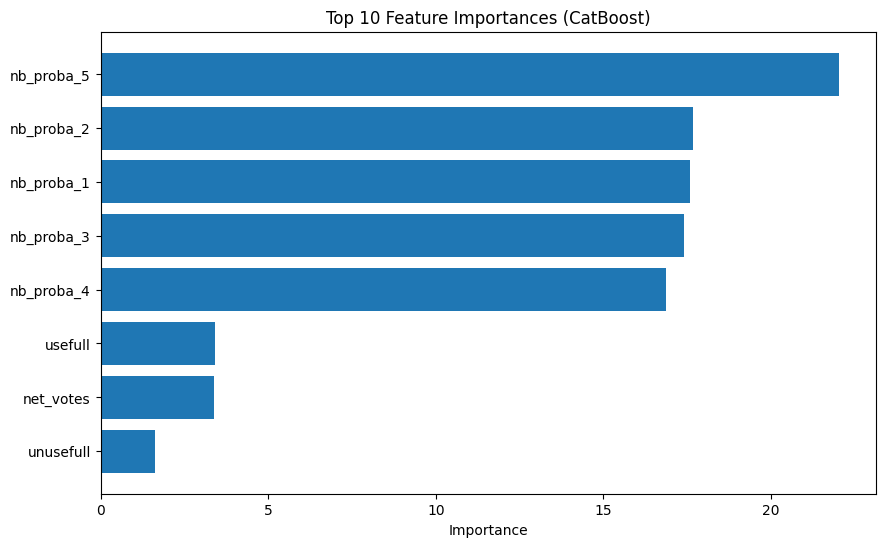

In [35]:
import matplotlib.pyplot as plt

feature_importances = cat_model.get_feature_importance(prettified=True)
feature_importances = feature_importances.sort_values('Importances', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature Id'][:10], feature_importances['Importances'][:10])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (CatBoost)")
plt.gca().invert_yaxis()
plt.show()

In [45]:
df_test = pd.read_csv('test.csv')
df_test['net_votes'] = df_test['usefull'] - df_test['unusefull']

X_test_vec = vectorizer.transform(df_test['review_text'])

X_nb_test = nb.predict_proba(X_test_vec)

X_test_catboost = pd.DataFrame(X_nb_test, columns=[f'nb_proba_{i}' for i in range(1, 6)])
X_test_catboost = pd.concat([X_test_catboost, df_test[['usefull', 'unusefull', 'net_votes']].reset_index(drop=True)], axis=1)

y_pred_test = cat_model.predict(X_test_catboost)

if len(y_pred_test.shape) > 1:
    y_pred_test = y_pred_test.ravel()
    
submission = pd.DataFrame({
    '_id': df_test['_id'],
    'stars': y_pred_test
})

submission.to_csv('submission.csv', index=False)

In [46]:
import joblib

joblib.dump(vectorizer, 'vectorizer.joblib')
joblib.dump(nb, 'nb_model.joblib')
cat_model.save_model('catboost_model.cbm')